# Data pre-processing for Climate Spirals Visualisation

In [1]:
%matplotlib inline
import pandas as pd
from pandas_datapackage_reader import read_datapackage
import matplotlib.pyplot as plt
from scipy import stats
plt.style.use("ggplot")

## CO<sub>2</sub> emissions from the Global Carbon Budget


Historical CO<sub>2</sub> emissions are taken from the [Global Carbon Budget](https://www.globalcarbonproject.org/carbonbudget/18/data.htm), using the CSV version from https://github.com/openclimatedata/global-carbon-budget

In [2]:
gcb = read_datapackage("https://github.com/openclimatedata/global-carbon-budget", "historical-budget")

In [3]:
co2 = (gcb[["Fossil-Fuel-Industry", "Land-Use-Change"]].loc[1850:] * 3.66 )
co2.tail()

,Fossil-Fuel-Industry,Land-Use-Change
Year,,
2014,35.18724,6.07194
2015,35.20188,6.23664
2016,35.34096,5.62542
2017,35.77284,5.37654
2018,36.53412,5.52294


In [4]:
co2["Total"] = co2[["Fossil-Fuel-Industry", "Land-Use-Change"]].sum(axis=1)

In [5]:
co2.tail()

,Fossil-Fuel-Industry,Land-Use-Change,Total
Year,,,
2014,35.18724,6.07194,41.25918
2015,35.20188,6.23664,41.43852
2016,35.34096,5.62542,40.96638
2017,35.77284,5.37654,41.14938
2018,36.53412,5.52294,42.05706


array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f48c757bd90>,
      dtype=object)

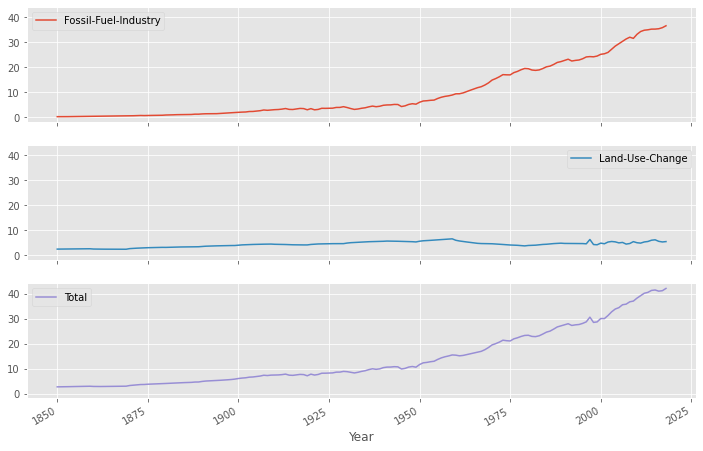

In [6]:
co2.plot(subplots=True, sharey=True, figsize=(12,8))

Export for visualisation

In [7]:
export = pd.DataFrame({"value": co2["Total"]})
export.index.name = "year"

In [8]:
export.reset_index().to_csv("../public/emissions.csv", index=False, float_format='%g')
export.tail()

,value
year,
2014,41.25918
2015,41.43852
2016,40.96638
2017,41.14938
2018,42.05706


## CO<sub>2</sub> concentrations

CO<sub>2</sub> concentrations are taken from the [CMIP6 concentration dataset](http://www.climate-energy-college.net/cmip6), version from 1 July 2016, combined with data from [ESRL/NOAA](https://www.esrl.noaa.gov/gmd/ccgg/trends/gl_data.html).


In [9]:
noaa = pd.read_csv("co2_mm_gl.txt", comment="#", parse_dates=[[0, 1]], index_col=[0], delim_whitespace=True, header=None,
                  names=["year", "month", "decimal", "average", "trend"])

noaa.head()

,decimal,average,trend
year_month,,,
1980-01-01,1980.042,338.45,337.82
1980-02-01,1980.125,339.15,338.10
1980-03-01,1980.208,339.47,338.13
1980-04-01,1980.292,339.87,338.25
1980-05-01,1980.375,340.30,338.78


In [10]:
cmip6 = pd.read_csv(
    "mole_fraction_of_carbon_dioxide_in_air_input4MIPs_GHGConcentrations_CMIP_UoM-CMIP-1-1-0_gr3-GMNHSH_000001-201412.csv",
)
cmip6.index = (cmip6.year.astype(str).apply(lambda x: x.zfill(4)) + 
    "-" + 
   cmip6.month.astype(str).apply(lambda x: x.zfill(2)) +
    "-01"
)
cmip6 = cmip6.iloc[21000:]
cmip6.index = pd.to_datetime(cmip6.index)
cmip6 = cmip6.drop(['datenum', 'datetime', 'day'], axis=1)
cmip6.head()

,year,month,data_mean_global,data_mean_nh,data_mean_sh
1750-01-01,1750,1,277.813529,278.492749,277.134309
1750-02-01,1750,2,278.196558,279.148898,277.244218
1750-03-01,1750,3,278.538475,279.791418,277.285531
1750-04-01,1750,4,278.779124,280.326118,277.232131
1750-05-01,1750,5,278.723560,280.230610,277.216510


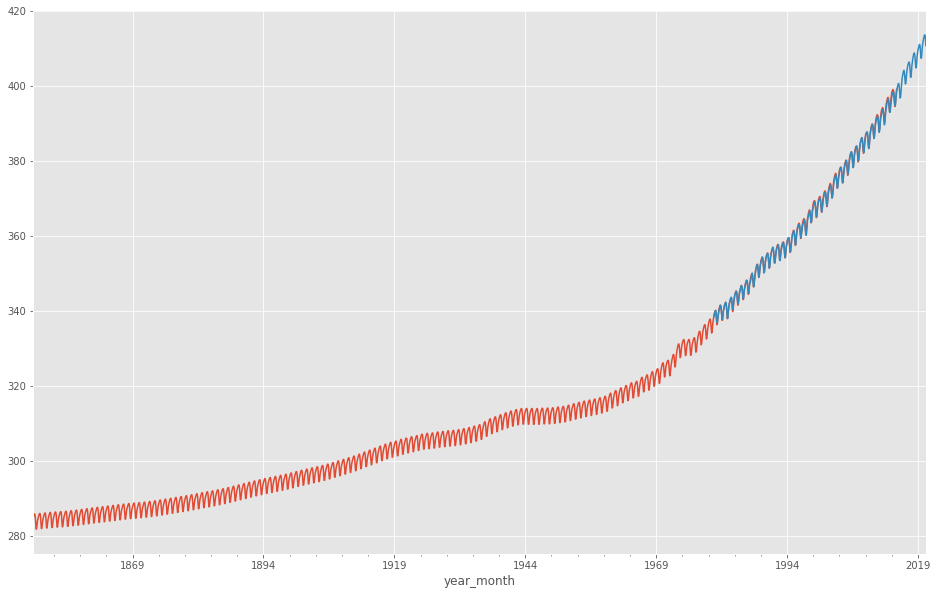

In [11]:
fig, ax = plt.subplots(1,1, figsize=(16,10))
cmip6.loc["1850":]["data_mean_global"].plot(ax=ax)
noaa["average"].plot(ax=ax)

In [12]:
cmip6.loc["1850":].rename(columns={"data_mean_nh": "value"}).to_csv("../public/concentrations_nh.csv", index=False)
cmip6.loc["1850":].rename(columns={"data_mean_sh": "value"}).to_csv("../public/concentrations_sh.csv", index=False)

combined = pd.concat([cmip6["data_mean_global"].loc["1850":"1979-12"], noaa["average"]])
combined = pd.DataFrame({"value": combined})
combined["year"] = combined.index.year
combined["month"] = combined.index.month
combined.index.name = "date"
combined["day"] = 15
combined = combined[["year", "month", "value"]]
combined.to_csv("../public/concentrations.csv", index=False)


In [13]:
combined.tail()

,year,month,value
date,,,
2020-03-01,2020,3,413.29
2020-04-01,2020,4,413.67
2020-05-01,2020,5,413.59
2020-06-01,2020,6,412.56
2020-07-01,2020,7,410.80


## Global Temperatures

Global temperature data is taken from the HadCRUT4 near surface temperature dataset.

http://www.metoffice.gov.uk/hadobs/hadcrut4/data/current/download.html

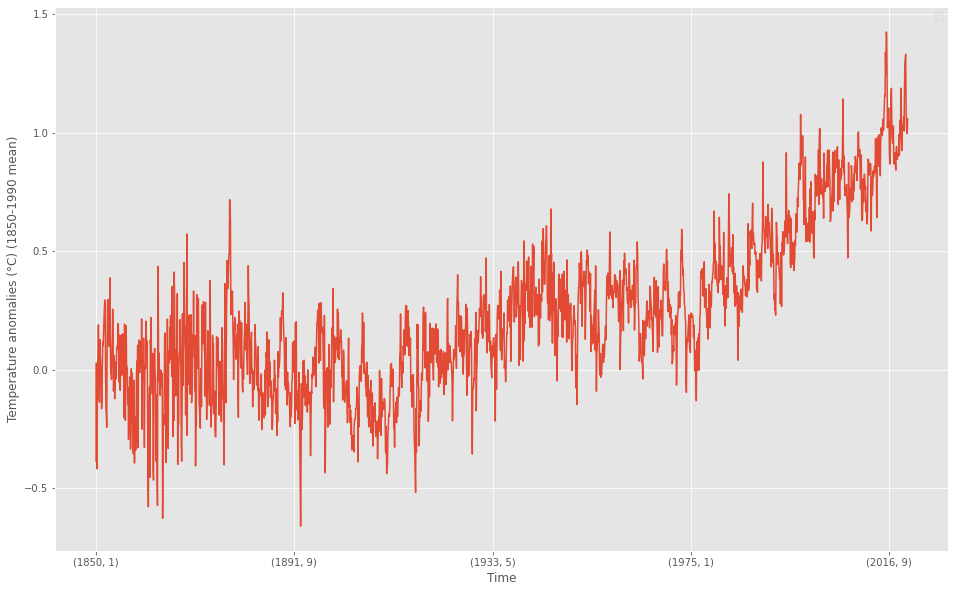

In [14]:
hadcrut = pd.read_csv(
    "HadCRUT.4.6.0.0.monthly_ns_avg.txt",
    delim_whitespace=True,
    usecols=[0, 1],
    header=None
)
hadcrut['year'] = hadcrut.iloc[:, 0].apply(lambda x: x.split("/")[0]).astype(int)
hadcrut['month'] = hadcrut.iloc[:, 0].apply(lambda x: x.split("/")[1]).astype(int)

hadcrut = hadcrut.rename(columns={1: "value"})
hadcrut = hadcrut.iloc[:, 1:]


hadcrut = hadcrut.set_index(['year', 'month'])

hadcrut -= hadcrut.loc[1850:1900].mean()
hadcrut.plot(figsize=(16,10))
hadcrut = hadcrut.reset_index()
plt.xlabel("Time")
plt.ylabel(u"Temperature anomalies (°C) (1850-1990 mean)")
plt.legend("")

In [15]:
hadcrut.tail()

,year,month,value
2043,2020,4,1.113441
2044,2020,5,1.027441
2045,2020,6,0.995441
2046,2020,7,1.008441
2047,2020,8,1.057441


In [16]:
hadcrut.to_csv("../public/temperatures.csv", index=False)